In [1]:
import numpy as np
import nengo
import matplotlib as mpl
import matplotlib.pyplot as plt
from nengo.utils.ensemble import tuning_curves
from nengo.dists import Uniform

In [2]:
nengo.rc.set("decoder_cache", "enabled", "false")

In [3]:
def make_neuron_population_and_compute_decoders(sigma=0.0, N=10):
    """
    sigma: regularisation parameter (0 means ignore noise). This
    will internally be multiplied by the maximum neural firing
    rate.
    N: number of neurons in the population.
    """    
    #import time
    #np.random.seed(int(time.time() * 10000000) & 0xFFFFFFFF)
    model = nengo.Network()
    with model:
        # Defaults to LIF neurons, with random gains and biases for neurons
        # between 100-200hz over -1,1
        neurons = nengo.Ensemble(
            N, dimensions=1, max_rates=Uniform(100,200))

        # This is just to generate the decoders
        connection = nengo.Connection(
            neurons, neurons,
            solver=nengo.solvers.LstsqL2(reg=sigma))

    # Compute the decoders
    sim = nengo.Simulator(model, progress_bar=None)
    D = sim.data[connection].weights

    # Fetch the tuning curves
    xs, A = tuning_curves(neurons, sim)
    return D, A, xs

In [4]:
import multiprocessing
import sys

def single_trial(args):
    j, N = args
    sigma = 10e-3
    D, A, xs = make_neuron_population_and_compute_decoders(sigma, N)
    return j, \
           0.5 * np.mean(np.square(D @ A.T - xs.T)), \
           0.5 * np.square(sigma) * np.sum(np.square(D))

n_ns = 20
n_trials = 100
Es = np.zeros((2, n_ns, n_trials))
ns_log = np.linspace(0.1, 3, n_ns)
Ns = np.round(np.power(10, ns_log)).astype(int)
with multiprocessing.Pool() as pool:
    for i, N in enumerate(Ns):
        for j, E0, E1 in pool.imap(single_trial, [(j, N) for j in range(n_trials)]):
            Es[:, i, j] = E0, E1
            sys.stderr.write("\r{:0.2f}% done...".format(100 * (j + 1 + n_trials * i) / (n_trials * n_ns)))
            sys.stderr.flush()
    sys.stderr.write("\n")

100.00% done...


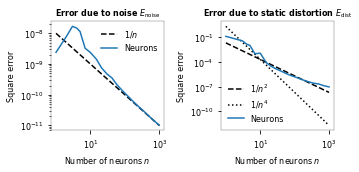

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 2.5))

ax1.loglog(Ns, 1e-8 / np.power(Ns, 1), 'k--', label="$1/n$")
ax1.loglog(Ns, np.mean(Es[1], axis=1), label="Neurons")
ax1.set_xlabel("Number of neurons $n$")
ax1.set_ylabel("Square error")
ax1.set_title("Error due to noise $E_\mathrm{noise}$");
ax1.legend()

ax2.loglog(Ns, 2e-2 / np.power(Ns, 2), 'k--', label="$1/n^2$")
ax2.loglog(Ns, 2 / np.power(Ns, 4), 'k:', label="$1/n^4$")
ax2.loglog(Ns, np.mean(Es[0], axis=1), label="Neurons")
ax2.set_xlabel("Number of neurons $n$")
ax2.set_ylabel("Square error")
ax2.set_title("Error due to static distortion $E_\mathrm{dist}$")
ax2.legend()

fig.tight_layout()
fig.savefig("../error_experiment.pdf", transparent=True, bbox_inches='tight')